<a href="https://colab.research.google.com/github/Xiujuan-XJ/Python-Unsupervised-Learning/blob/master/PhD_Teach_PhD_Workshop_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About COLAB**

Let's note that COLAB [https://research.google.com/colaboratory/faq.htmlis](https://) is a Cloud (delocalised) computing ressource product from Google. Computation is done on Google's servers not on your computer. You can interact very intuitively with this distant computer from this browser window. 

This is convinient as it gives you some free computing ressources and because you don't need to install any programming libraries on your computer. You just need a Google account.

But this comes with a privacy and security drawback. Google has access to everything in your Colab and Drive. This means you should be careful not too put sentivite healthcare data here!!! 

For this workshop, we are working on a publicaly avaiable anonimized healhcare dataset, so that's ok. But, for other heathcare projects, you may need to do this from your own desktop or from your NUS lab server.

# Introduction (5min)

see slides



**Raise the goal/question we can answer on this dataset using data-driven approaches introduced this morning?**

*Answer:*

# Part 0: Environment set up (10min)

Some useful documentation links:

- Pandas (DataFrames): https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html
- Matplotlib (Visualisation): https://matplotlib.org/stable/index.html
- Seaborn (Advanced Visualisation compatible with Pandas) https://seaborn.pydata.org/examples/index.html
- Scikit-Learn (Machine Learning): https://scikit-learn.org/stable/user_guide.html

In [ ]:
# Import useful libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

!pip install umap-learn
import umap

import sklearn

     |████████████████████████████████| 80 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 10.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=84e2efd1c155b820c0d437b469d35f2621dd541433ad8d3fff699bb02dfb52f6
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=2c85413ead0fc551e1676962daf351600208b3c589cbbffed76d8193cb24edf9
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


**Why is it important to fix a seed value?**

*Answer:*

In [ ]:
# Seed value for reproducibility purpose

seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [ ]:
# Set up your working directory on Colab

drive.mount('/content/gdrive', force_remount=True) # mount drive
os.chdir('/content/gdrive/My Drive/PhD-teach-PhD workshop') # change current working directory
print(os.getcwd()) # print current working directory
print(os.listdir(os.getcwd())) # print content of current working directory

Mounted at /content/gdrive
/content/gdrive/My Drive/PhD-teach-PhD workshop
['physionet.org', 'PhD_Teach_PhD_Day1_PM_Ronald.pptx', 'PhD_Teach_PhD_Day1_AM_Ronald.pptx', 'PhD_Teach_PhD_Day2_AM_Ronald.pptx', 'PhD_teach_PhD_Day2_AM_Hanae.pptx', 'PhD_teach_PhD_Day1_AM_Hanae.pptx', 'PhD_teach_PhD_Day1_AM_Hanae copy.pptx', 'PhD-teach-PhD workshop prep.gdoc', 'dataset_split', 'PhD_Teach_PhD_Day2_PM_Ronald.pptx', 'PhD_Teach_PhD_Day1_AM_updated_Profs_suggestions.pptx', 'model_evaluation_complete_Ronald.ipynb', 'model.png', 'Updated_versions_ronald', 'Slides - final version', 'Tutorial.ipynb']


# Part 1: Database preparation (30min)

Raffa, J. (2016). Clinical data from the MIMIC-II database for a case study on indwelling arterial catheters (version 1.0). PhysioNet. https://doi.org/10.13026/C2NC7F.


In [ ]:
# download the MIMIC dataset
!wget -b -r -N -c -q -o -np https://physionet.org/files/mimic2-iaccd/1.0/ # download the MIMIC-II dataset from url
print(os.listdir(os.getcwd()+'/physionet.org/files/mimic2-iaccd/1.0/')) # print the folder content

Continuing in background, pid 535.
['data_dictionary.txt', 'full_cohort_data.csv', 'aline-mimic-ii-master.zip', 'LICENSE.txt', 'SHA256SUMS.txt', 'index.html']


In [ ]:
# read dataset as a Pandas dataframe
data_df = pd.read_csv('physionet.org/files/mimic2-iaccd/1.0/full_cohort_data.csv') # read dataset as a DataFrame

**In the studied dataset:**

**How many patients/observations/samples are they? How many variables describe each patient?** (hint: use .shape Pandas attribute)

**Print/Display the 5 first lines to get a preview of the dataset** (hint: use .head() Pandas function)

In [ ]:
# Anwser


The 'data_dictionary' text file will give you more detailed information about the different clinial features.

In [ ]:
# get feature description and guess feature type (categorical / numerical)
data_dict = pd.read_csv('physionet.org/files/mimic2-iaccd/1.0/data_dictionary.txt', sep='\t', skiprows=1, header=None) # read description file
data_dict.columns = ['col']
data_dict['feature'] = data_dict.col.str.split(pat=': ', n=2, expand=True)[0].str.lstrip()
data_dict['description'] = data_dict.col.str.split(pat=': ', n=2, expand=True)[1]
data_dict['type'] = 'unknown' # initialise variable type column to unknown
data_dict['type'][data_dict['description'].str.contains('numeric')] = 'numerical' # if description contains 'numeric' -> numerical variable
data_dict['type'][data_dict['description'].str.contains('binary')] = 'binary' # if description contains 'binary' -> numerical binary
data_dict['type'][data_dict['description'].str.contains('character')] = 'categorical' # if description contains 'character' -> categorical variable
data_dict['type'][data_dict['feature'] == 'gender_num'] = 'categorical' # excpetion for gender -> categorical variable
data_dict.set_index('feature', inplace=True) # feature name as dataframe index
data_dict.drop('col', axis=1, inplace=True) # drop 'col' column
print(data_dict.groupby('type').size()) # count number of variable per type
data_dict

type
binary         16
categorical     3
numerical      27
dtype: int64


description         type
feature                                                                           
aline_flg                         IAC used (binary, 1 = year, 0 = no)       binary
icu_los_day                     length of stay in ICU (days, numeric)    numerical
hospital_los_day           length of stay in hospital (days, numeric)    numerical
age                                  age at baseline (years, numeric)    numerical
gender_num                        patient gender (1 = male; 0=female)  categorical
weight_first                              first weight, (kg, numeric)    numerical
bmi                                            patient BMI, (numeric)    numerical
sapsi_first                              first SAPS I score (numeric)    numerical
sofa_first                                 first SOFA score (numeric)    numerical
service_unit                          type of service unit (character  categorical
service_num                              service as a numeric (binary       binary
day_icu_intime               day of week of ICU admission (character)  categorical
day_icu_intime_num  day of week of ICU admission (numeric, corresp...    numerical
hour_icu_intime     hour of ICU admission (numeric, hour of admiss...    numerical
hosp_exp_flg                                death in hospital (binary       binary
icu_exp_flg                                      death in ICU (binary       binary
day_28_flg                               death within 28 days (binary       binary
mort_day_censored   day post ICU admission of censoring or death (...    numerical
censor_flg                                  censored or death (binary       binary
sepsis_flg                                     sepsis present (binary       binary
chf_flg                              Congestive heart failure (binary       binary
afib_flg                                 Atrial fibrillation  (binary       binary
renal_flg                               Chronic renal disease (binary       binary
liver_flg                                       Liver Disease (binary       binary
copd_flg                Chronic obstructive pulmonary disease (binary       binary
cad_flg                               Coronary artery disease (binary       binary
stroke_flg                                             Stroke (binary       binary
mal_flg                                            Malignancy (binary       binary
resp_flg                       Respiratory disease (non-COPD) (binary       binary
map_1st                        Mean arterial pressure (mmHg, numeric)    numerical
hr_1st                                           Heart Rate (numeric)    numerical
temp_1st                                     Temperature (F, numeric)    numerical
spo2_1st                                          S_pO_2 (%, numeric)    numerical
abg_count           arterial blood gas count (number of tests, num...    numerical
wbc_first                first White blood cell count (K/uL, numeric)    numerical
hgb_first                            first Hemoglobin (g/dL, numeric)    numerical
platelet_first                        first Platelets (K/u, numericL)    numerical
sodium_first                            first Sodium (mEq/L, numeric)    numerical
potassium_first                      first Potassium (mEq/L, numeric)    numerical
tco2_first                         first Bicarbonate (mEq/L, numeric)    numerical
chloride_first                        first Chloride (mEq/L, numeric)    numerical
bun_first                  first Blood urea nitrogen (mg/dL, numeric)    numerical
creatinine_first                    first Creatinine (mg/dL, numeric)    numerical
po2_first                                 first PaO_2 (mmHg, numeric)    numerical
pco2_first                               first PaCO_2 (mmHg, numeric)    numerical
iv_day_1                    input fluids by IV on day 1 (mL, numeric)    numerical

**What target output feature(s)/label(s) do you reckon relevant to attempt predicting?** 

**Create the observation data matrix X by dropping all output clinical features** (hint: use pandas function drop)

**Create the target variable y corresponding to the output label that we selected together**

In [ ]:
# Anwser


**What is the current dimension of your observation data X?**

**Count and display the repartition of your target (binary) output?** (hint: use sns.countplot function)

**What comment can you make?**

In [ ]:
# Anwser


# Part 2: Standard pre-processing (15min)

In healthcare, as in many other fields, you often come accross unstructured datasets with missing values, different scales for the same features, etc. This is not the funniest step, but you definitely need to ensure your dataset is clean for the rest of your analysis.


## Cleaning data

**Is there any nan values in your dataset?** (hint: use pandas .isnull() attribute function)

**Drop all (patient,output) item containing NaN values** (hint: use .dropna() attribute function)

**Check your new dataset shape**

In [ ]:
# Anwser


We have an issue as machine learning model can handle only numeric input variables.

For categorical variable, we can use ordinal encoding. For instance, 'day_icu_intime_num' turned the week days into numbers: Monday -> 1, Tuesday -> 2, etc.

But, the encoding can be inadequate at best for categorical variables with no ordinal relationship. For week days, the ordinal encoding is not very relevant. A more compeling example is the variable 'gender' where male is encoded as 1 and female as 0. It is a pure convention here as the purpose is not to indicate a hierachy in gender but to distinguish genders. However, if we keep it this way, the model will consider male is higher/better than female. 

To solve this, we can use *one-hot-encoding*. It is a popular way to deal with categorical features. It creates a new column for each unique value in the original category column (gender variable will turn into 2 'dummy' variables: gender_male and gender_female). The zeros and ones are subsequently put in these dummy variables (1 meaning TRUE, 0 meaning FALSE).

This artifically increases the number of features.

**Perform one-hot-encoding on categorical features that are not binary in the observation matrix X** (hint: use pandas get_dummies function)

**Check your new dataset shape**

In [ ]:
# Answer


## Split train val test

**Split dataset into train  and test set with proportions 2/3 and 1/3 respectively. Pick random_state=42 for reproducibility purposes. Plus, as the dataset is relatively small, ensure the proportion of target labels in train and test set is similar.** (hint: use scikit-learn train_test_split function)

**IMPORTANT: keep your test dataset for the end. If you use your test data to finetuned your model, you will overfit.**

In [ ]:
# Answer


In [ ]:
X_train_val, y_train_val = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])
dataset_train_val = pd.concat([X_train_val, y_train_val], axis=1)

# Part 3: Visualisation & Feature Engineering (1h)

 We did not insist on it in the lectures as we wanted to spend more time on the understanding of the different models. But we will spend time on it in the tutorial as this is **a crucial step** in all machine learning / deep learning / data-driven approaches!

Do not overlook this step! In practice, in a machine learning project, you would usually spend 80% of your time on pre-processing and feature selection and 20% on model training and selection. That's how it is in real life.

## Dataset Visualisation

In [ ]:
dataset_train = pd.concat([X_train, y_train], axis=1)

### Principal Component Analysis (PCA)

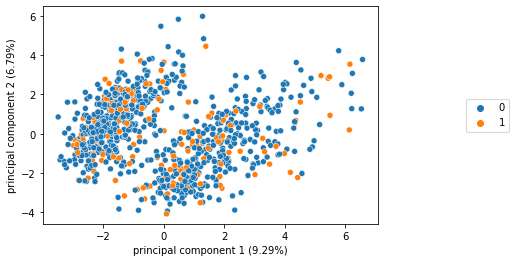

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline_pca = sklearn.pipeline.Pipeline([('scaler', StandardScaler()), ('PCA', sklearn.decomposition.PCA(random_state=42))])
pipeline_pca.fit(X_train_val)
principalComponents = pipeline_pca.transform(X_train_val)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component '+str(i+1)+' ({:.2f}%)'.format(pipeline_pca['PCA'].explained_variance_ratio_[i]*100) 
for i in range(principalComponents.shape[1])])
finalDf = pd.concat([principalDf, data_df], axis = 1)

plt.figure()
f = sns.scatterplot(x='principal component 1 ({:.2f}%)'.format(pipeline_pca['PCA'].explained_variance_ratio_[0]*100),
                    y='principal component 2 ({:.2f}%)'.format(pipeline_pca['PCA'].explained_variance_ratio_[1]*100),
                    hue=target_label, data=finalDf, legend="full")
f.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)


aline_flg


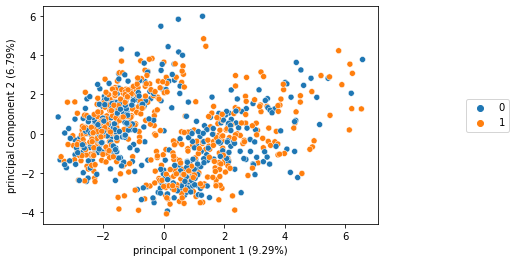

icu_los_day


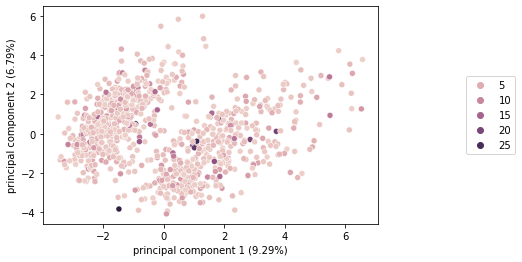

hospital_los_day


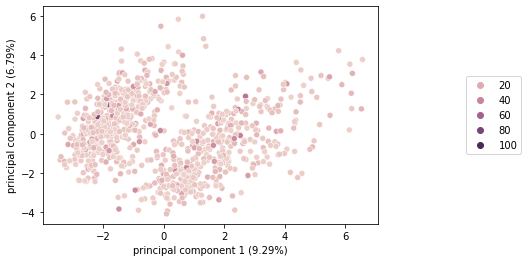

age


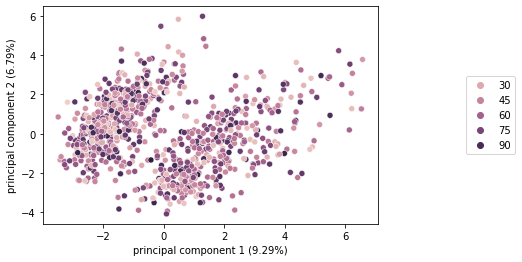

gender_num


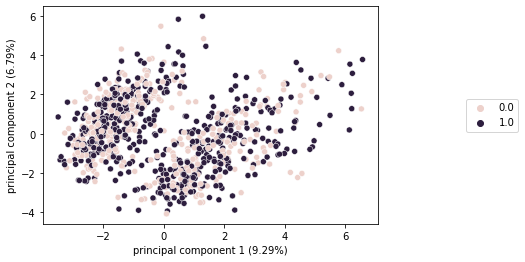

weight_first


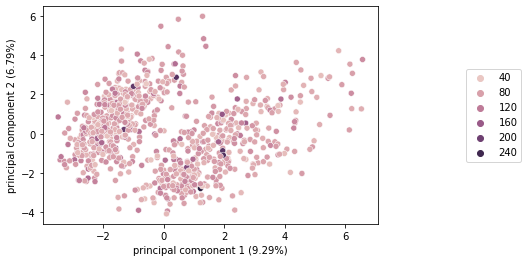

bmi


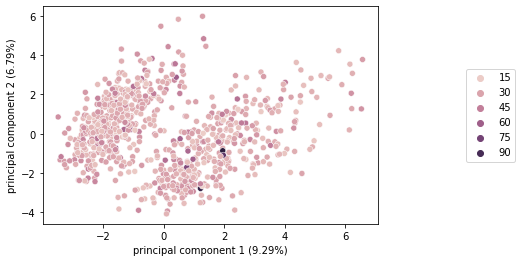

sapsi_first


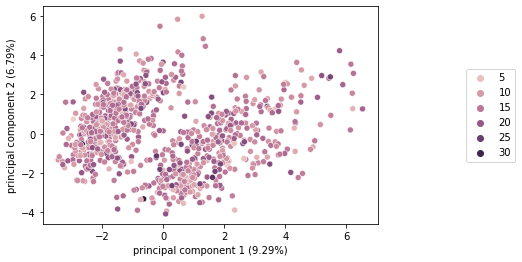

sofa_first


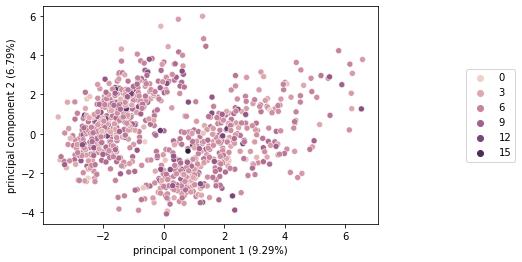

service_unit


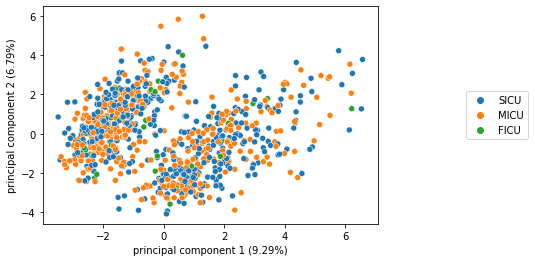

service_num


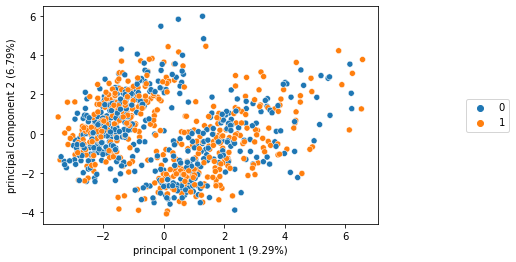

day_icu_intime


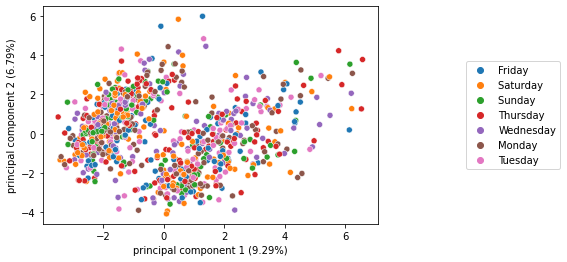

day_icu_intime_num


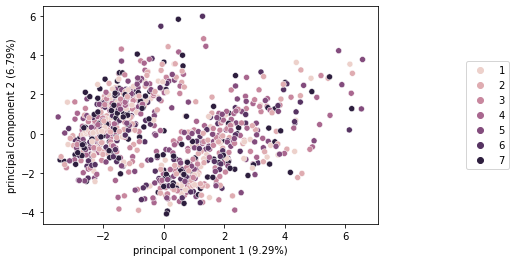

hour_icu_intime


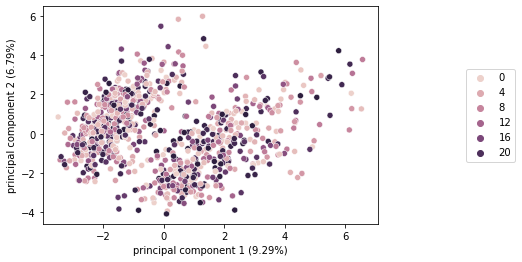

hosp_exp_flg


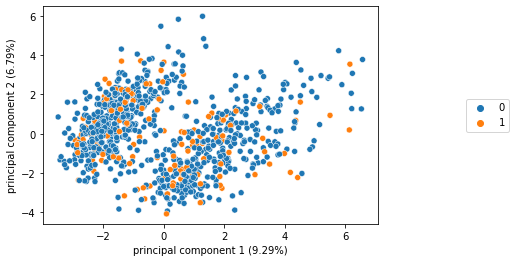

icu_exp_flg


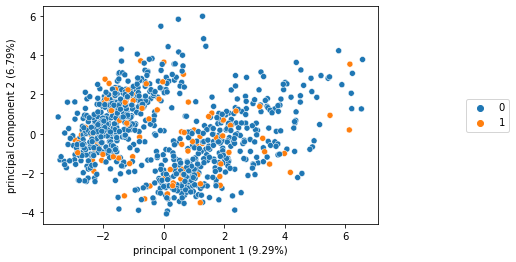

day_28_flg


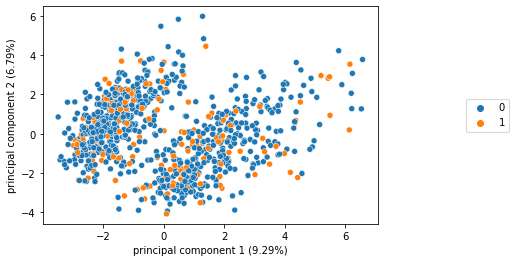

mort_day_censored


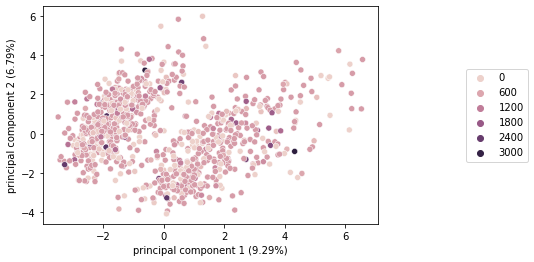

censor_flg


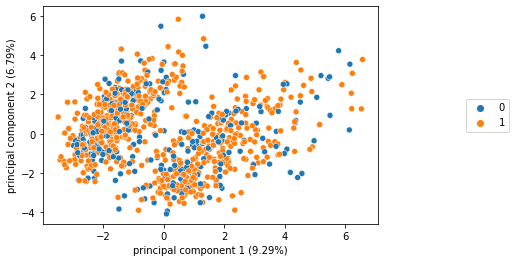

sepsis_flg


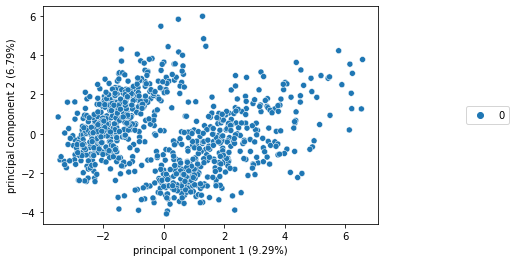

chf_flg


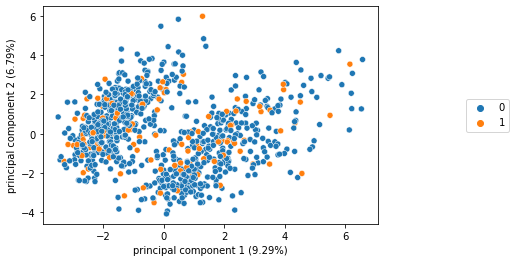

afib_flg


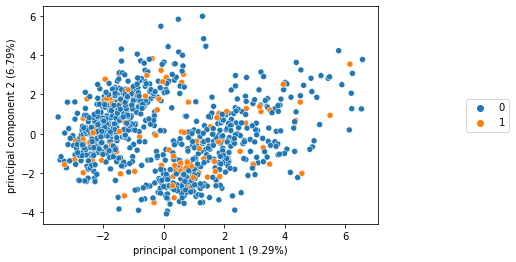

renal_flg


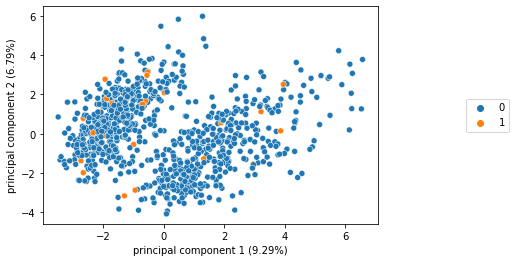

liver_flg


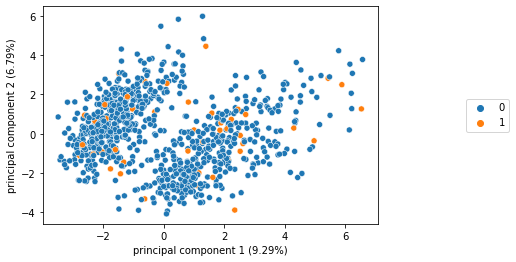

copd_flg


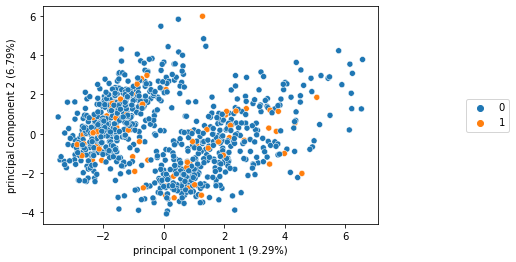

cad_flg


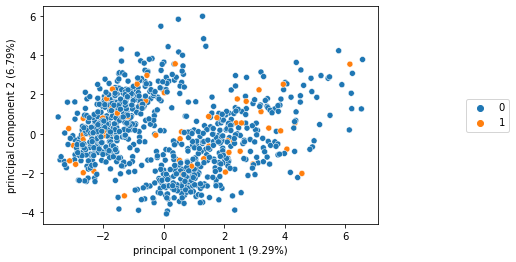

stroke_flg


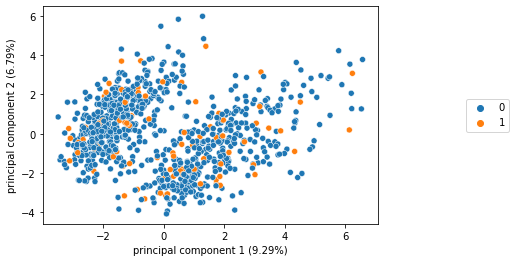

mal_flg


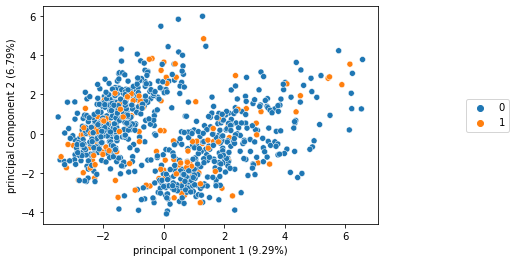

resp_flg


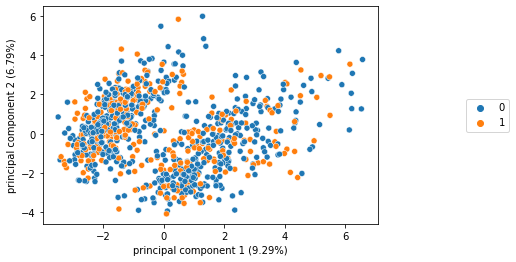

map_1st


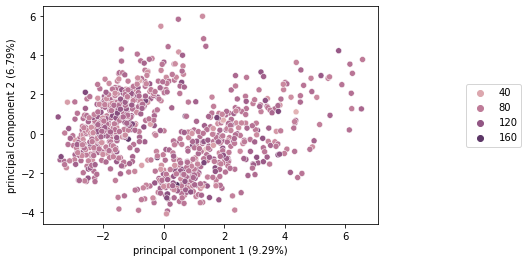

hr_1st


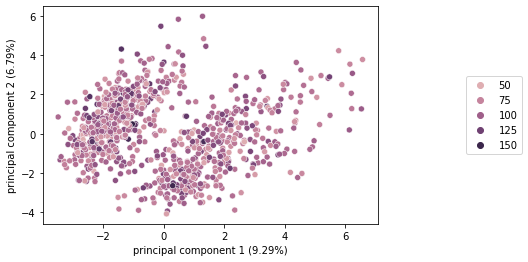

temp_1st


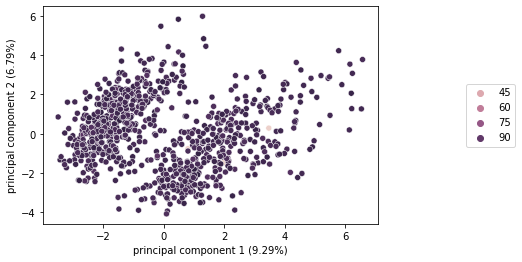

spo2_1st


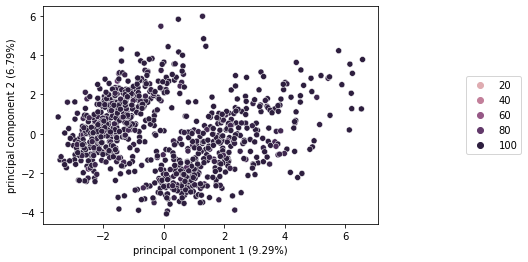

abg_count


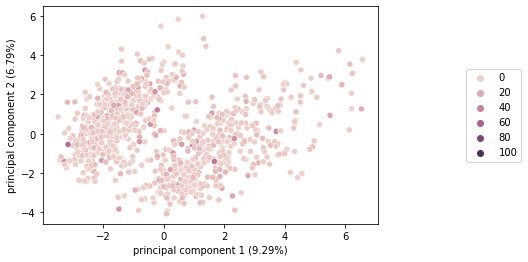

wbc_first


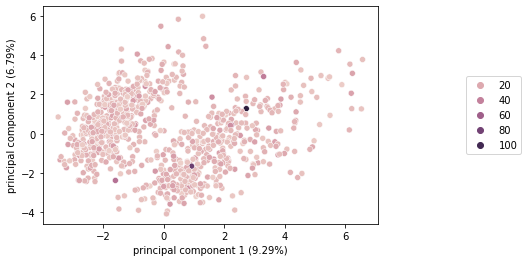

hgb_first


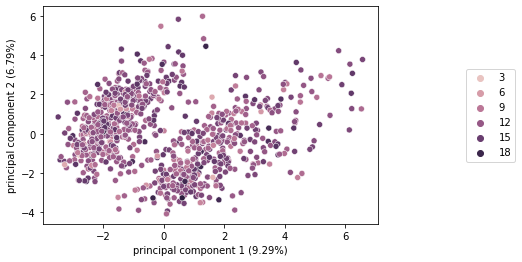

platelet_first


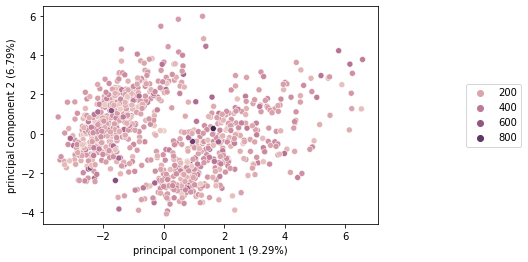

sodium_first


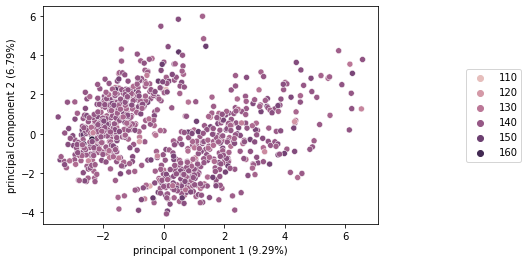

potassium_first


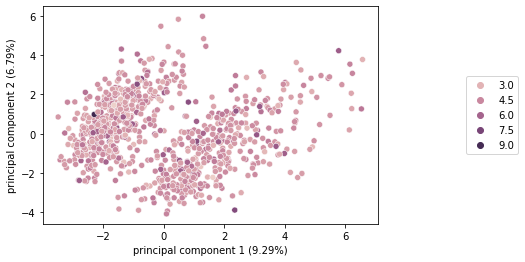

tco2_first


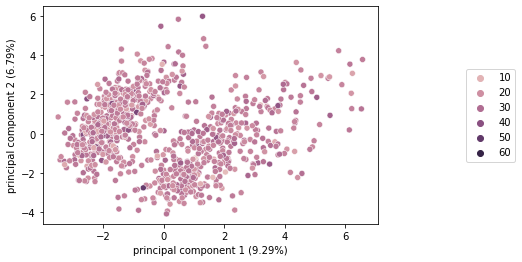

chloride_first


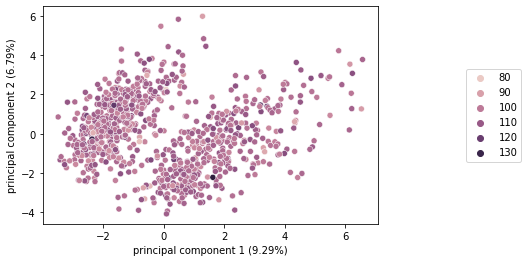

bun_first


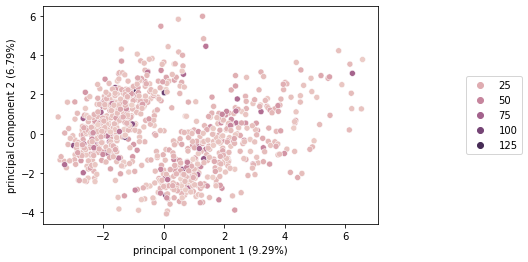

creatinine_first


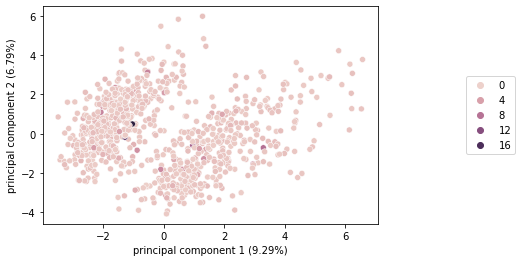

po2_first


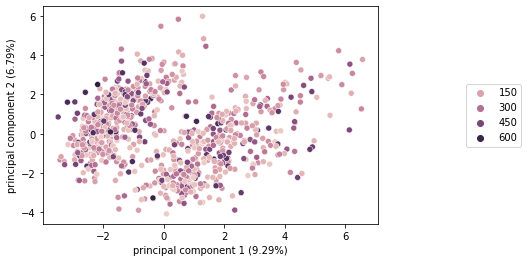

pco2_first


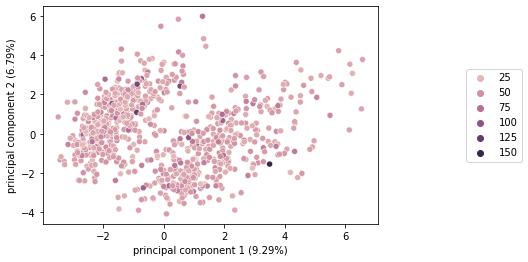

iv_day_1


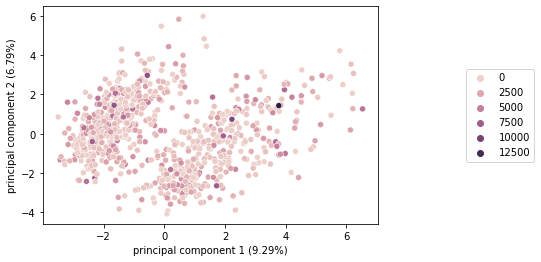

In [ ]:
for huelabel in data_df.columns:
  print(huelabel)
  plt.figure()
  f = sns.scatterplot(x='principal component 1 ({:.2f}%)'.format(pipeline_pca['PCA'].explained_variance_ratio_[0]*100),
                      y='principal component 2 ({:.2f}%)'.format(pipeline_pca['PCA'].explained_variance_ratio_[1]*100),
                      hue=huelabel, data=finalDf)
  f.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
  plt.show()

### UMAP

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Text(0.5, 1.0, 'UMAP projection of the dataset')

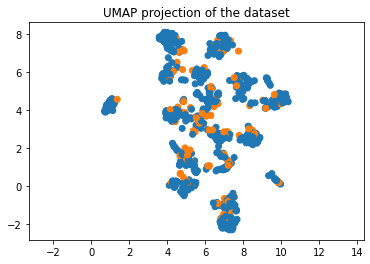

In [ ]:
# UMAP

reducer = umap.UMAP()
embedding = reducer.fit_transform(StandardScaler().fit_transform(X_train_val))
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in y_train_val])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset')

## Summary Statistics

Here are boxplots to visualise the range or repartition of each feature. **What comments can you make?**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d66e40b10>,
      dtype=object)

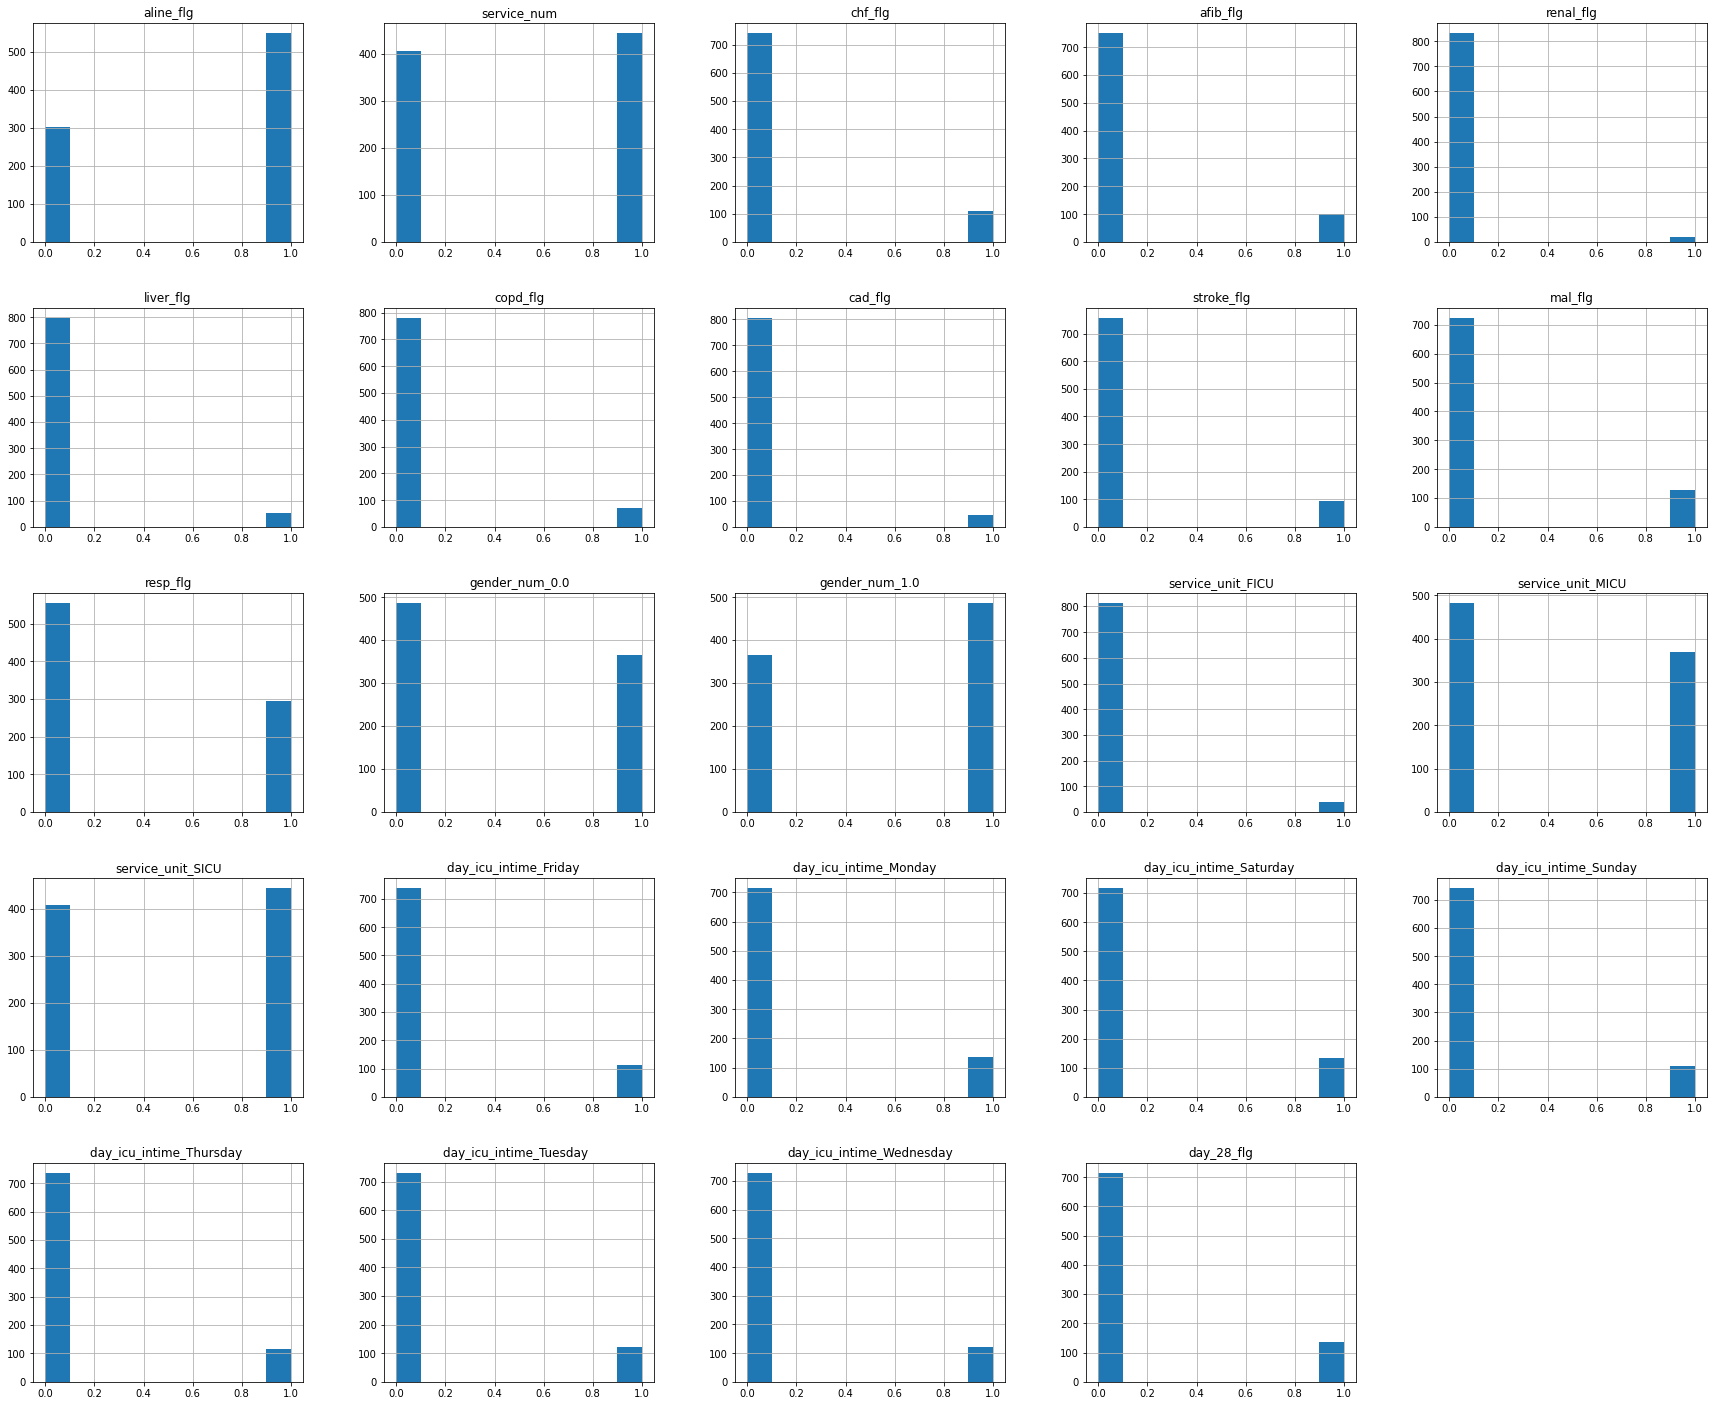

In [ ]:
binary_vars = [feature for feature in dataset_train_val.columns if dataset_train_val[feature].max() == 1]

dataset_train_val[binary_vars].hist(figsize=(30,25))

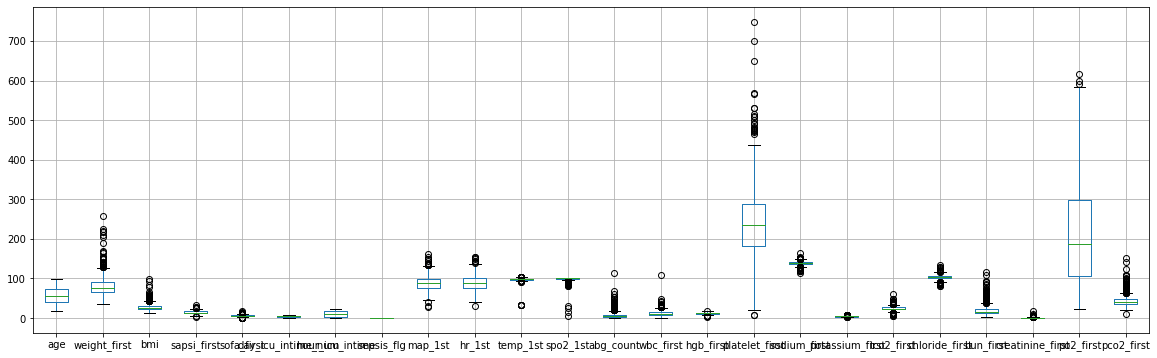

In [ ]:
dataset_train_val[[f for f in dataset_train_val.columns if f not in binary_vars and f != 'iv_day_1']].boxplot(figsize=(20,6))

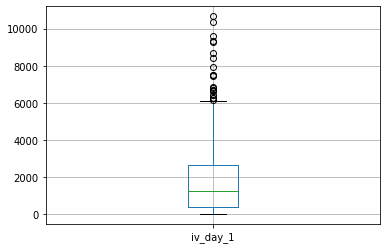

In [ ]:
dataset_train_val[['iv_day_1']].boxplot()

## Correlation between variables

Here is the correlation matrix between each sets of 2 features. **What comments can you make?**

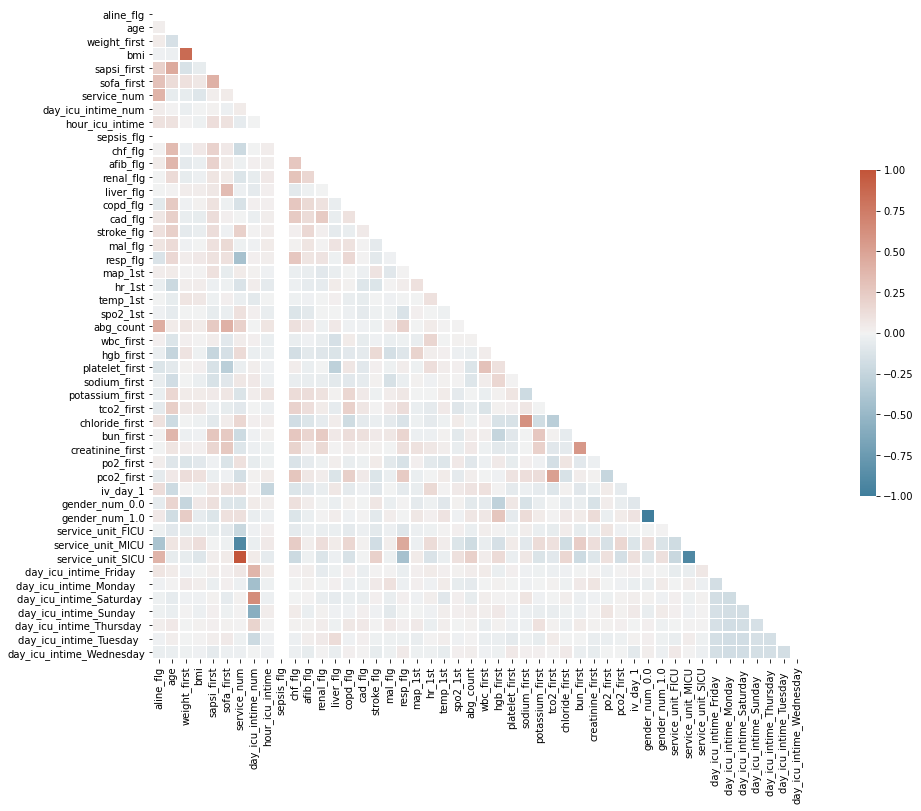

In [ ]:
# correlation matrix

# Compute the correlation matrix
corr = X_train_val.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Correlation with output variable

Here is the (Pearson, linear) correlation between each feature and the target label. **What comments can you make?**

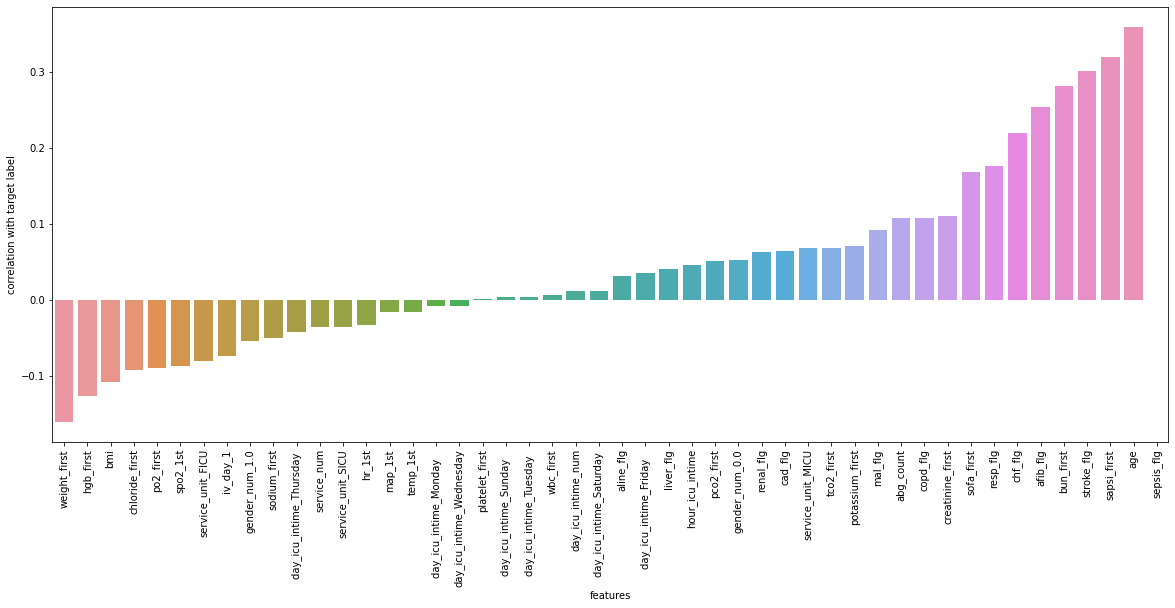

In [ ]:
corrwithtarget = X_train_val.corrwith(y_train_val).to_frame()
corrwithtarget.reset_index(inplace=True)
corrwithtarget.columns = ['features', 'correlation with target label']
corrwithtarget.sort_values(by='correlation with target label', inplace=True)
fig, ax = plt.subplots(figsize=(20,8))
pp = sns.barplot(x='features', y='correlation with target label', data=corrwithtarget, ax=ax)
for item in pp.get_xticklabels():
    item.set_rotation(90)

# Part 4: Classifier implementation (1h)

## Logistic Regression

**Implement a logistic regression model to predict target y from observation data X. To do so, create a model pipeline that performs data normalisation and logistic regression with default hyper-parameters. Fit the pipeline on your training data and evaluate on the validation data. Use ROC AUC score as a scoring metric.** (hint: use sklearn Pipeline and StandardScaler)

In [ ]:
#answer

## Support Vector Machine

**Implement a support vector machine model to predict target y from observation data X. To do so, create a model pipeline that performs data normalisation and support vector machine with default hyper-parameters. Fit the pipeline on your training data and evaluate on the validation data. Use ROC AUC score as a scoring metric.** (hint: use sklearn Pipeline and StandardScaler)

In [ ]:
#answer

## K-Nearest Neigboors

**Implement a K-Nearest Neigboors model to predict target y from observation data X. To do so, create a model pipeline that performs data normalisation and K-Nearest Neigboors with default hyper-parameters. Fit the pipeline on your training data and evaluate on the validation data. Use ROC AUC score as a scoring metric.** (hint: use sklearn Pipeline and StandardScaler)

In [ ]:
#answer

**Plot the classification accuracy and fit time according to the number of neighboors K. From those plots, pick a good value for K.
Implement a new K-Nearest Neighboors model using this K value and test performance on validation data.**

In [ ]:
#answer

In [ ]:
#answer

## Multi Layer Perceptron


### MLP with scikit-learn

**Implement a Multi Layer Perceptron model to predict target y from observation data X. To do so, create a model pipeline that performs data normalisation and Multi Layer Perceptron with the following hyper-parameters:**
- 2 hidden layers with size 1024 for layer 1 and 512 for layer 2
- Mini-Batch Stochastic Gradient Descent as optimizing algorithm with a batch size of 100 items
- an adaptive learning rate
- a maximum number of epochs of 2000

**Fit the pipeline on your training data and evaluate on the validation data. Use ROC AUC score as a scoring metric.** (hint: use sklearn Pipeline and StandardScaler)

In [ ]:
#answer

## Random Forest

Implement a Random Forest model to predict target y from observation data X.

In [ ]:
#answer

## List of models

In [ ]:
models_dict = {
    'logistic regression': modelpipe_logisticreg,
    'SVM': modelpipe_svm,
    'KNN': modelpipe_knn,
    'KNN finetuned': modelpipe_knn_finetuned,
    'MLP':modelpipe_mlp,
    'Random Forest': modelpipe_rf,
}

# Part 5: K-fold Cross-Validation (15min)

**Implement K-fold Cross Validation with K=5 on the training + validation dataset.** (Hint: Use sklearn KFold function to do it manually or cross_val_score)

In [ ]:
# Answer


# Part 6: Advanced Metrics (15min)

## ROC curve

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


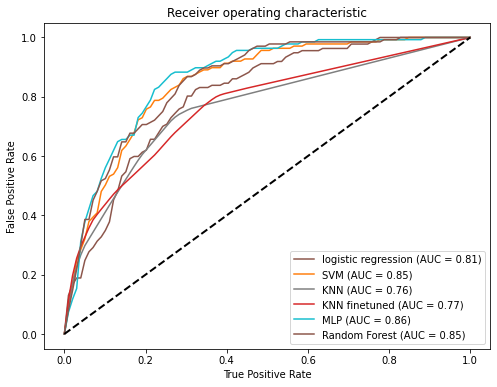

In [ ]:
# Run classifier with cross-validation and plot ROC curves

cv = sklearn.model_selection.StratifiedKFold(n_splits=5)


fig, ax = plt.subplots(figsize=(8,6))
for modelname, classifier in models_dict.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, val) in enumerate(cv.split(X_train_val, y_train_val)):
        classifier.fit(X_train_val[train], y_train_val[train])
        viz = sklearn.metrics.plot_roc_curve(classifier, X_train_val[val], y_train_val[val],
                         alpha=0, lw=0, name='aux', ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, label=modelname + ' (AUC = {:.2f})'.format(mean_auc))

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic")
handles, labels = ax.get_legend_handles_labels()
idx_leg = [i for i, lab in enumerate(labels) if not lab.startswith('aux')]
ax.legend([h for i, h in enumerate(handles) if i in idx_leg], [l for i, l in enumerate(labels) if i in idx_leg], loc="lower right")
ax.set_xlabel('True Positive Rate')
ax.set_ylabel('False Positive Rate')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance')
plt.show()

## Confusion matrix

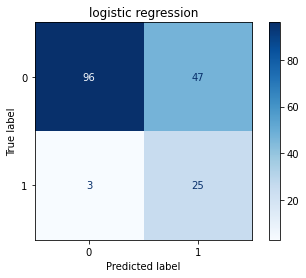

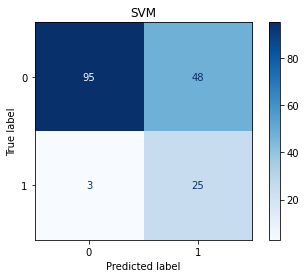

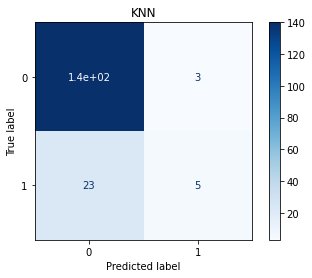

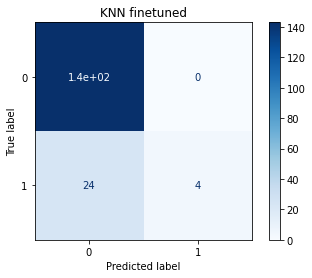

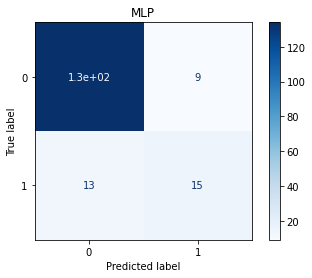

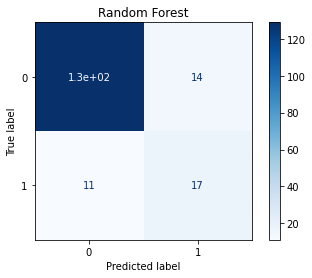

In [ ]:
from sklearn.metrics import plot_confusion_matrix

for modelname, classifier in models_dict.items():
  cm = plot_confusion_matrix(classifier, X_val, y_val, cmap=plt.cm.Blues)
  cm.ax_.set_title(modelname)

# Part 7: Hyper-parameter tuning (1h)

You saw that beyond training, models have several hyperparameters that can really change how well they fit your data.
We are going to learn here how to do grid search to select good hyperparameters.
**In practice, this is a crucial and time-consuming step.**
More advanced grid search envolves random grid search (not testing all combinaisons but a sample).

## Logistic Regression

**Perform grid search on your logistic regression pipeline to find the best regularisation (l1 or l2 regularisation? strength of the regularisation?) using 5-fold cross validation to optimize ROC AUC score**

In [ ]:
#answer

## Support Vector Machine

**Perform grid search on your support vector machine pipeline to find a good regularisation, a good kernel and a good kernel parameter using 5-fold cross validation to optimize ROC AUC score**

In [ ]:
#answer

## Multi Layer Perceptron

In [ ]:
#answer

# Part 8: Final model comparison (15min)

**Build your table of results in 5-fold CV scores and test scores for each model**

In [ ]:
models_dict = {
    'logistic regression': modelpipe_logisticreg,
    'logistic regression finetuned': modelpipe_logisticreg_finetuned,
    'SVM': modelpipe_svm,
    'SVM finetuned': modelpipe_svm_finetuned,
    'KNN': modelpipe_knn,
    'KNN finetuned': modelpipe_knn_finetuned,
    'MLP':modelpipe_mlp,
    'MLP finetuned':modelpipe_mlp_finetuned,
    'Random Forest': modelpipe_rf,
    #'Random Forest finetuned': modelpipe_rf_finetuned,
}

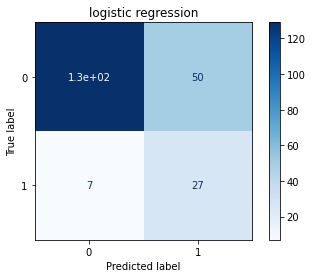

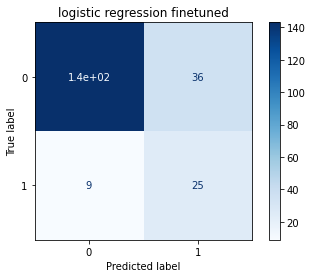

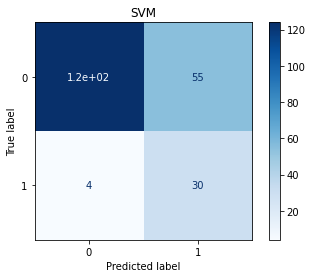

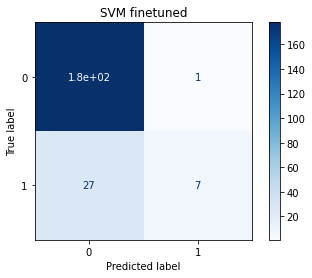

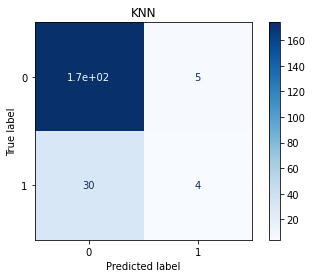

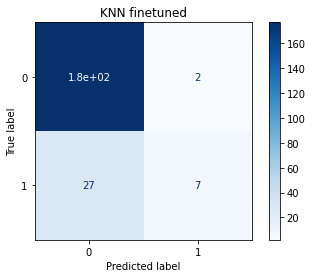

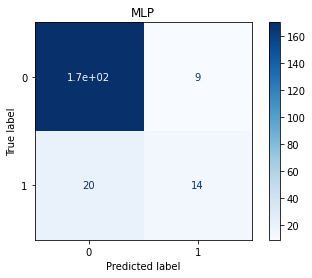

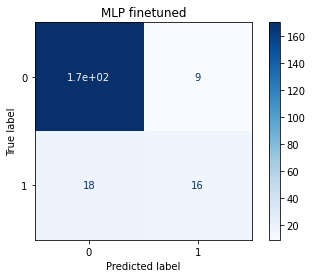

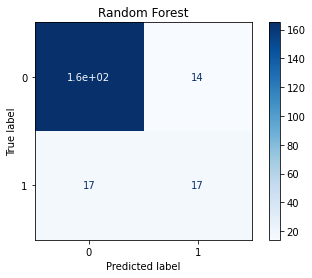

In [ ]:
from sklearn.metrics import plot_confusion_matrix

for modelname, classifier in models_dict.items():
  cm = plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues)
  cm.ax_.set_title(modelname)

In [ ]:
pd_results = pd.DataFrame.from_dict({
    'model': list(models_dict.keys()),
    '5-fold CV accuracy': [np.mean(sklearn.model_selection.cross_val_score(modelpipe, X_train_val, y_train_val, cv=5, scoring='accuracy')) for modelpipe in list(models_dict.values())],
    'test accuracy': [modelpipe.score(X_test, y_test) for modelpipe in list(models_dict.values())],
    'test ROC AUC': [sklearn.metrics.roc_auc_score(y_test, modelpipe.predict(X_test)) for modelpipe in list(models_dict.values())],
    'test f1_score': [sklearn.metrics.f1_score(y_test, modelpipe.predict(X_test)) for modelpipe in list(models_dict.values())],

})

pd_results.set_index('model', inplace=True)

pd_results


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


5-fold CV accuracy  ...  test f1_score
model                                              ...               
logistic regression                      0.730925  ...       0.486486
logistic regression finetuned            0.793161  ...       0.526316
SVM                                      0.746144  ...       0.504202
SVM finetuned                            0.839030  ...       0.333333
KNN                                      0.847238  ...       0.186047
KNN finetuned                            0.846054  ...       0.325581
MLP                                      0.858975  ...       0.491228
MLP finetuned                            0.858975  ...       0.542373
Random Forest                            0.844850  ...       0.523077

[9 rows x 4 columns]

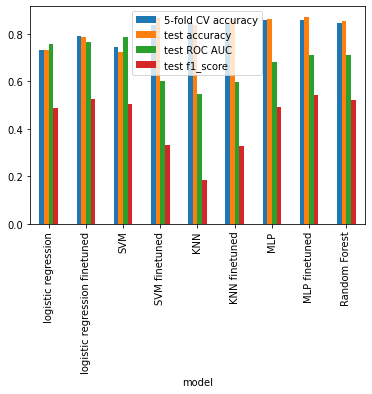

In [ ]:
pd_results.plot(kind='bar')

# Conclusion


**What comments can you make on model performances?**

**What could you do next to increase performance?**

**Can those results give you hints about how these model types will perform on another dataset?**